# Probabilistic Programming in Python using PyMC

Authors: John Salvatier, Thomas V. Wiecki, Christopher Fonnesbeck

## Introduction
Probabilistic Programming (PP) allows flexible specification of statistical Bayesian models in code. PyMC3 is a new, open-source PP framework with an intutive, readable yet powerful syntax that is close to the natural syntax statisticians use to describe models. It features next generation Markov chain Monte Carlo (MCMC) sampling algorithms such as the No-U-Turn Sampler (NUTS; Hoffman, 2014). This class of samplers work well on high dimensional and complex posterior distributions and allows us to fit many previously difficult models without specialized knowledge about fitting algorithms. 

Much of PyMC3's ease of use on difficult problems comes from the No-U-Turn Sampler (NUTS), a self-tuning variant of Hamiltonian Monte Carlo (HMC; Duane, 1987). HMC and NUTS take advantage of gradient information from the likelihood to achieve much faster convergence than traditional sampling methods, especially for larger models. NUTS also has several self tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo, which means you usually don't need to have specialized knowledge about how the algorithms work. PyMC3 and the Stan (Stan Development Team, 2014) package, are currently the only PP packages to offer HMC.

Probabilistic programming in Python confers a number of advantages including multi-platform compatibility, ease of use (particularly for non-computer scientists), ease of integration with other scientific libraries and extensibility. PyMC3 is designed to be easy to extend. It is simple and straightforward to write and use custom statistical distributions, samplers and transformation functions.

While most of PyMC3 is written in pure Python, it leverages Theano (Bergstra et al., 2010) to transparently transcode models to C and compile it to machine code, thereby boosting performance. Theano also automatically optimizes the likelihood's computational graph for speed and provides simple GPU integration.

Key PyMC3 features include:

  * Intuitive model specification syntax, for example, x ~ N(0,1) translates to x = Normal(0,1)
  * Powerful sampling algorithms such as Hamiltonian Monte Carlo
  * Easy optimization for finding the maximum a posteriori point
  * Theano features
    *   Numpy broadcasting and advanced indexing
    *   Linear algebra operators
    *   Computation optimization and dynamic C compilation, GPU integration
  * Simple extensibility
  * Database backends for storing simulation output
  * Parallel sampling


## Outline

We will first see the basics of how to use PyMC3 with a simple toy example: installation, data creation, model definition, model fitting and posterior analysis. Then we will cover two case studies and use them to show how to define and fit more sophisticated models. Finally we will show how to extend PyMC3 and discuss other useful features.

## Installation

Running PyMC3 requires a working Python interpreter, either version 2.7 (or more recent) or 3.4 (or more recent); we recommend that new users install version 3.4. A complete Python installation for Mac OSX, Linux and Windows can most easily be obtained by downloading the free [`Anaconda Python Distribution`](https://store.continuum.io/cshop/anaconda/) by ContinuumIO, and installing it. 

`PyMC3` can also be installed manually using `pip` (https://pip.pypa.io/en/latest/installing.html):

```
pip install git+https://github.com/pymc-devs/pymc3
```

PyMC3 depends on several third-party Python packages which will be automatically installed when installing via pip. The four required dependencies are: `Theano`, `NumPy`, `SciPy`, and `Matplotlib`. To take full advantage of PyMC, the optional dependencies `Pandas` and `Patsy` should also be installed. These are *not* automatically installed, but can be installed by:

```
pip install patsy pandas
```

The source code for PyMC is hosted on GitHub at https://github.com/pymc-devs/pymc3 and is distributed under the liberal [Apache License 2.0](https://github.com/pymc-devs/pymc3/blob/master/LICENSE). On the GitHub site, users may also report bugs and other issues, as well as contribute code to the project, which we actively encourage.


##PyMC3 Basics

To introduce model definition, fitting and posterior analysis, we first consider the following basic Bayesian model for linear regression with normal priors for the parameters.

$$\begin{aligned} 
\alpha &\sim \mathcal{N}(0, 1) \\
\beta &\sim \mathcal{N}(0, 1) \\
\sigma &\sim \lvert\mathcal{N}(0, 1){\rvert}\\
Y  &\sim \mathcal{N}(\alpha + X \beta, \sigma)
\end{aligned}$$

where $X$ is the observed vector of predictors, and $Y$ is the observed vector outcome vector; $\alpha$ the intercept, and $\beta$ the slope regression coefficients which follow a standard normal distribution. $\sigma$ represents the error term and is modeled as the absolute of a Normal distribution (so-called *HalfNormal*).

###Generating data

We can simulate some artificial data from this model using only NumPy (no PyMC3), and then use PyMC3 to estimate the corresponding parameters. The structure of the generation code closely follows the PyMC3 model construction.

In [1]:
import numpy as np

# Intialize random number generator
np.random.seed(123)

# True parameter values
alpha, beta, sigma = 1, 1, 1

# Size of dataset
size = 100

# Predictor variable
X = np.linspace(0, 1, size)

# Simulate outcome variable
Y = alpha + X*beta + np.random.randn(size)*sigma

Here is what the simulated data look like.

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


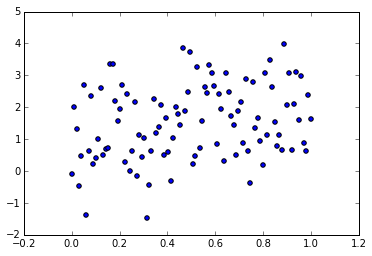

In [2]:
%pylab inline
import pylab as pl

pl.scatter(X, Y);

###Model Specification

Specifiying this model in PyMC3 is straightforward because the syntax is as close to writing pseudo-code as possible. For the most part, each line of Python code corresponds to a line in the model notation above. 

First, we import the components we will need from PyMC.

In [3]:
from pymc3 import Model, Normal, HalfNormal

:0: FutureWarning: IPython widgets are experimental and may change in the future.


Now we build our model, which we will present in full first, then explain what the different parts do.

In [1]:
basic_model = Model()
with basic_model:
    
    # Unknown model parameters
    alpha = Normal('alpha', mu=0, sd=1)
    beta = Normal('beta', mu=0, sd=1)
    sigma = HalfNormal('sigma', sd=1)
    
    # Expected value of outcome
    mu = alpha + beta * X
    
    # Data likelihood
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

NameError: name 'Model' is not defined

The first line creates a new `Model` which represents our model as a whole and will store all our random variables.

The `with` statement denotes a Python *context manager* and sets our `basic_model` as the context until the indented block ends. This means all PyMC3 objects introduced in the indented code block below it are added to the model behind the scenes. Absent this context manager idiom, we would be forced to manually associate each of the variables with `basic_model` right after we create them. If you try to create a new random variable outside of a `with model:` statement, the creation will fail since there is no obvious model for the variable to be added to.

The next line creates a **stochastic** random variable called "alpha" with a Normal prior distribution with a mean of 0 and precision of 1. It is stochastic because its value is only partly determined by its parents (random variables that determine its prior distribution), though it has no parents in this case. 

We call the `Normal` constructor to construct a random variable with a normal prior. The first argument is the *name* of the random variable, in this case "alpha". This should almost always match the name of the Python variable being assigned to. Next are the parameters of the prior distribution, in this case "mu", the mean, and "sd", the standard deviation. In most cases these are are one or two values which determine the location, shape or scale of the prior distribution for random variable, depending on the parameterization of the distribution.


The next two lines similarly create two other stochastic random variables `beta` and `sigma`, with `sigma` using a half-normal distribution as a prior. Most commonly used distributions, such as `Beta`, `Exponential`, `Categorical`, `Gamma`, `Wishart` and many others, are available.  

Detailed notes about distribution, sampling methods and other PyMC3 functions are available via the `help` function.

In [5]:
help(Normal) #try help(Model), help(Uniform) or help(basic_model)

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Normal log-likelihood.
 |  
 |  .. math::
ight\}
 |  
 |  Parameters
 |  ----------
 |  mu : float
 |      Mean of the distribution.
 |  tau : float
 |      Precision of the distribution, which corresponds to
 |      :math:`1/\sigma^2` (tau > 0).
 |  sd : float
 |      Standard deviation of the distribution. Alternative parameterization.
 |  
 |  .. note::
 |  - :math:`E(X) = \mu`
 |  - :math:`Var(X) = 1/        au`
 |  
 |  Method resolution order:
 |      Normal
 |      pymc3.distributions.distribution.Continuous
 |      pymc3.distributions.distribution.Distribution
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, mu=0.0, tau=None, sd=None, *args, **kwargs)
 |  
 |  logp(self, value)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from pymc3.distributions.distribution.Distribut

The line defining `mu` creates a **deterministic** random variable, meaning that its value is completely determined by its parents' values. There is no uncertainty beyond the uncertainty in the parents' values. Here, `mu` is just the sum of the intercept `alpha` and the product of the slope `beta` and the predictor variable. PyMC3 random variables and data can be arbitrarily added, subtracted, divided and multiplied together, to create new random variables allowing for great model expressivity. Many common mathematical functions like `sum`, `sin`, `exp` and linear algebra functions like `dot` are also provided. 

The final line of the model, defining `Y_obs`, is an **observed stochastic**, and represents the data likelihood of the model. It provides the evidence from the data to the model, and is identical to a standard stochastic, except that it is given an `observed` argument. This is how the data are passed to the model, in the form of a `numpy.ndarray` or `pandas.DataFrame` object, and indicates to PyMC3 that the value of the node has been observed and thus should not change.

Instead of setting its parameters to constants, we set the mean of the distribution to `mu` and the standard deviation to `sigma`.



###Model fitting
Now that we have specified our model, we want to summarize the posterior into histograms, means, variances, correlations etc. so we can explore and understand it. 

For most models and summary functions of interest there is no general way to compute the summaries analytically and the parameter space many naive numerical methods are too expensive. Two techniques do often work well: finding the *maximum a posteriori* (MAP) point, which can be done using optimization methods, and computing summaries based on samples drawn from the posterior distribution using Markov Chain Monte Carlo (MCMC) sampling methods.

####Maximum a posteriori methods

The **maximum a posteriori (MAP)** estimate for a model, is the mode of the posterior distribution and is generally found using numercal optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn't representative of the distribution. PyMC3 provides this functionality with the `find_MAP` function.

Below we find the MAP for our original model. The MAP is returned as a parameter **point**, which is always represented by a Python dictionary of variable names to NumPy arrays of parameter values. 

In [6]:
from pymc3 import find_MAP

start = find_MAP(model=basic_model)
    
print(start)

{'alpha': array(1.0330430050855257), 'beta': array(0.9621492333808841), 'sigma': array(1.1214199375548823)}


By default, `PyMC3` uses Broyden–Fletcher–Goldfarb–Shanno (BFGS) algorithm to find the maximum of the log-posterior but also allows selection of other optimization algorithms from the `scipy.optimize` module. For example, below we use Powell's method to find the MAP.

In [7]:
from scipy import optimize

start = find_MAP(model=basic_model, fmin=optimize.fmin_powell)
    
print(start)

{'alpha': array(1.0333820240232854), 'beta': array(0.9618748957713651), 'sigma': array(1.1207891768840499)}


**WARNING**
The MAP point is not always a reasonable estimate, especially if the mode is at an extreme. 

This can be a subtle issue. With high dimensional posteriors, one can have areas of extremely high density but low total probability because the volume is very small. This will often come up with the two scale parameters for hierarchical models. If the individual group means are all the same, the posterior will have near infinite density if the scale parameter for the group means is almost zero even though the probability of such a small scale parameter will be small since the group means must be extremely close together.

Most techniques for finding the MAP point only find a *local* MAP point, which is often good enough, but can fail badly for multimodal posteriors if the different modes are meaningfully different.

####Sampling methods

Though MAP is a fast and easy way of obtaining estimates of the unknown model parameters, it is not usually sufficient for inference because there is no associated estimate of uncertainty of the MAP estimates. Instead, a simulation-based approach such as Markov chain Monte Carlo (MCMC) can be used to obtain a Markov chain of values that, given the satisfaction of certain conditions, are indistinguishable from independent samples from the true posterior. 

To conduct MCMC sampling to generate posterior samples in PyMC3, we instantiate a **step method** object that corresponds to a particular MCMC algorithm, such as Metropolis or Slice sampling or the No-U-Turn Sampler (NUTS). PyMC3's `step_methods` submodule contains the following samplers: `NUTS`, `Metropolis`, `Slice`, `HamiltonianMC`, and `BinaryMetropolis`.

####Advanced sampling methods

PyMC3 has the standard sampling algorithms like Metropolis-Hastings and slice sampling, but PyMC3's speciality is the No-U-Turn Sampler (`NUTS`; Hoffman, 2014), a self-tuning variant of Hamiltonian Monte Carlo (HMC; Duane, 1987). HMC and NUTS are especially useful on models that have many parameters (where standard algorithms work very slowly). They advantage of gradient information from the likelihood to achieve much faster convergence on large problems than traditional sampling methods. PyMC3 relies on Theano to analytically compute model gradients via automatic differentation on the computational graph that PyMC3's syntax specifies. NUTS also has several self tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo. For random variables that are undifferentiable NUTS and HMC cannot be used.

Both NUTS and HMC require a scaling matrix, which is much like the precision matrix for the jump proposal distribution in Metropolis-Hastings, althrough HMC and NUTS use it somewhat differently. The matrix gives the rough local shape of the distribution so that NUTS makes reasonable jump attempts.

It is often critical to set this scaling parameter reasonably well for good sampling. This is especially true for models that have many unobserved stochastics or models with highly non-normal posterior distributions. Bad scaling parameters will slow down NUTS significantly, sometimes almost stopping it completely. The starting point for sampling can also be important for efficient sampling, but not as often.

Fortunately NUTS can often make good guesses for the scaling parameters. If you pass a point in parameter space (as a dictionary of variable names to parameter values, the same format as returned by `find_MAP`) to HMC or NUTS it will look at the local curvature of the log posterior-density (the diagonal of the Hessian matrix) at that point to make a guess for a good scaling vector. This is often a good value.

Though we may not want to use MAP for inference, it is often a good point to use for finding a good scaling vector, as above. It also often makes a good starting point for sampling.

It is also possible to supply your own vector or scaling matrix to HMC/NUTS, though this is a more advanced use. If you wish to modify a Hessian at a specific point, to use as your scaling matrix or vector, you can use `find_hessian` or `find_hessian_diag`.

For our MCMC example, we will use NUTS to sample 500 draws from the posterior using the MAP as the starting point and scaling point. 

In [4]:
from pymc3 import NUTS, sample

with basic_model:
    
    # obtain starting values via MAP
    start = find_MAP(fmin=optimize.fmin_powell)
    
    # instantiate sampler
    step = NUTS(scaling=start) 
    
    # draw 500 posterior samples
    trace = sample(500, step, start=start) 

NameError: name 'basic_model' is not defined

The returned `trace` object can be queried in a similar way to a `dict` containing a map from variable names to `numpy.array`s. The first dimension of the array is the sampling index and the later dimensions match the shape of the variable. We can see the last 5 values for the `alpha` variable as follows

In [9]:
trace['alpha'][-5:]

array([ 0.80727203,  1.25000296,  1.26172503,  1.26172503,  1.23665847])

### Posterior analysis
`PyMC3` comes with various statistical and plotting capabilities to examine the output. A simple posterior plot can be created using `pymc3.traceplot`.

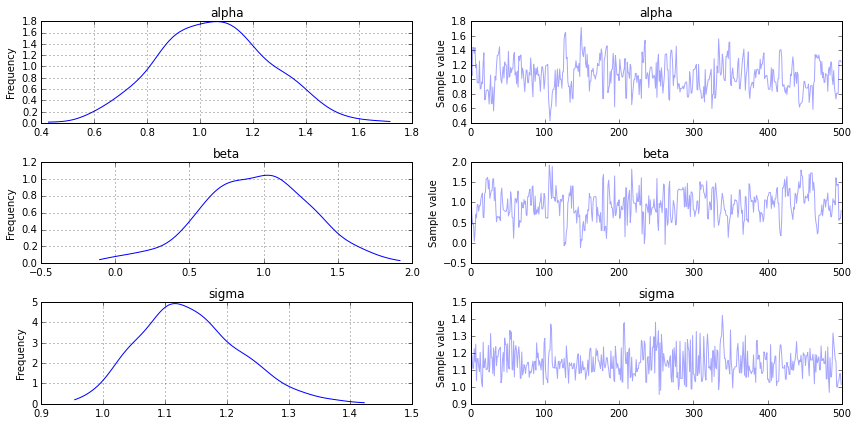

In [10]:
from pymc3 import traceplot

traceplot(trace);

The left column consists of a smoothed histogram (kernel density estimation) of the marginal posterios of each RV while the right column contains the trace plot of the Markov chain. As we ran four chains, each subplot will have 4 differently colored lines, one corresponding to each chain. This allows easy visual inspection of all chains.

In addition, `pymc3.summary()` provides a text-based output of common posterior statistics:

In [11]:
from pymc3 import summary

summary(trace)


alpha:
 
  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.055            0.209            0.016            [0.667, 1.454]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.661          0.908          1.055          1.196          1.453


beta:
 
  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.944            0.364            0.026            [0.272, 1.738]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.153          0.694          0.958          1.197          1.639


sigma:
 
  Mean             SD               MC Error         95% HPD interval
  -----------------------

##Case study 1: Stochastic volatility

We present a case study of stochastic volatility, time varying stock market volatility, to showcase some PyMC3 features. The following model has 400+ parameters so using common sampling algorithms like Metropolis Hastings would be extremely slow. Instead we use the No-U-Turn Sampler (NUTS), which is dramatically more efficient.

The distribution of returns is highly non-normal, which makes sampling the volatlities significantly more difficult. 

###The Model

Asset prices have time-varying volatility (variance of day over day `returns`). In some periods, returns are highly variable, while in others very stable. Stochastic volatility models model this with a latent volatility variable, modeled as a stochastic process. The following model is similar to the one described in the NUTS paper (Hoffman 2014, p. 21).

$$ \sigma \sim Exponential(50) $$

$$ \nu \sim Exponential(.1) $$

$$ s_i \sim Normal(s_{i-1}, \sigma^{-2}) $$

$$ log(y_i) \sim StudentT(\nu, 0, exp(-2 s_i)) $$

Here, $y$ is the daily return series which are modeled with a student-t distribution an unknown degrees of freedom and a scale parameter determined by a latent process $s$. The individual $s_i$ are the individual daily log volatilities in the latent log volatility process. 

###The Data

First we load the last 400 daily returns of the S&P 500.

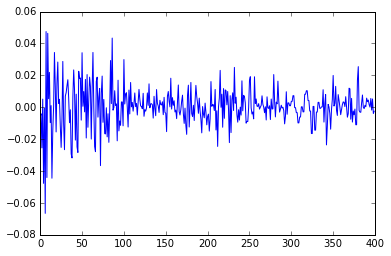

In [12]:
n = 400
returns = np.genfromtxt("data/SP500.csv")[-n:]
plot(returns)

###Model Specification
Specifying the model in PyMC3 mirrors its statistical specification. 

Here we use several new distributions the `Exponential` distribution for the $ \nu $ and $\sigma$ priors, the student-t (`T`) distribution for distribution of returns, and the `GaussianRandomWalk` for the prior for the latent volatilities.   

It is easier to sample the scale of the log volatility process innovations, $\sigma$, on a log scale, so we create it using `TransformedVar` and use `logtransform`. `TransformedVar` creates one variable in the transformed space and one in the normal space. The one in the transformed space (here $\text{log}(\sigma) $) is the one over which sampling will occur, and the one in the normal space is the one to use throughout the rest of the model.

It takes a variable name, a distribution and a transformation to use.

We can also provide a test value for any distribution using the `testval` argument. This overrides the default test value for the distribution (usually the mean, median or mode of the distribution), and is most often useful if some values are illegal and we want to ensure we select a legal one. The test values for the distributions are also used as a starting point for sampling and optimization by default, though this is easily overriden. 

The `s` vector is given a prior distribution by `GaussianRandomWalk`. As its name suggests GaussianRandomWalk is a vector valued distribution where the values of the vector form a random normal walk of length n (specified by `shape=n`). 

The `shape` argument used on the `GaussianRandomWalk` is available for all distributions and specifies the length or like shape of the random variable, it can also be a tuple to make multidimensional arrays (e.g. `shape=(5,7)` makes random variable that takes on 5 by 7 matrix values). 

The scale of the innovations of the random walk, `sigma`, is specified in terms of the precision of the normally distributed innovations and can be a scalar or vector. 

In [13]:
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk

with Model() as model:
    
    nu = pm.Exponential('nu', 1./10, testval=.1)
    
    sigma, log_sigma = model.TransformedVar('sigma', pm.Exponential.dist(1./.02, testval=.1),
                                            pm.logtransform)
    
    s = GaussianRandomWalk('s', sigma**-2, shape=n)

    r = pm.T('r', nu, lam=pm.exp(-2*s), observed=returns)

Notice we transform the log volatility process `s` into the volatility process by `exp(-2*s)`. The `exp()` function comes from Theano (imported through PyMC), which provides a wide varitety of common scientific computing funtions (and some uncommon ones).

###Fitting
Before we can draw samples from the posterior, we want to find a decent starting point by finding a point of relatively high probability. For this model, the full maximum a posteriori (MAP) point over all variables is degenerate and has infinite density. But, if we fix `log_sigma` and `nu` it is no longer degenerate, so we find the MAP with respect only to the volatility process, 's', keeping `log_sigma` and `nu` constant at their default values (remember that we set `testval=.1` for `sigma`).

We use Limited-memory BFGS (L-BFGS) provided by `scipy` as it is more efficient for high dimensional functions and we have 400 stochastic random variables (mostly from `s`).

To do the sampling, we do a short initial run to put us in a volume of high probability, then start again at the new starting point. `trace[-1]` gives us the last point in the sampling trace. NUTS will recalculate the scaling parameters based on the new point, and in this case it leads to faster sampling due to better scaling.

In [15]:
import scipy
with model:
    start = pm.find_MAP(vars=[s], fmin=scipy.optimize.fmin_l_bfgs_b)
    
    step = pm.NUTS(scaling=start)
    trace = pm.sample(500, step, progressbar=False)

    # Start next run at the last sampled position.
    step = pm.NUTS(scaling=trace[-1], gamma=.25)
    trace = pm.sample(4000, step, start=trace[-1])

 [-----------------100%-----------------] 4000 of 4000 complete in 802.6 sec

We also take advantage of multithreading, running 4 chains in parallel, by specifying `njobs=4`. That causes the `sample` function to return a `MultiTrace` object which works slightly differently than the `Trace` object. We can convert it to vanilla `Trace` object by using `merge_traces`.

We can check basic convergence by looking at the traceplot for `nu` and `log_sigma`.

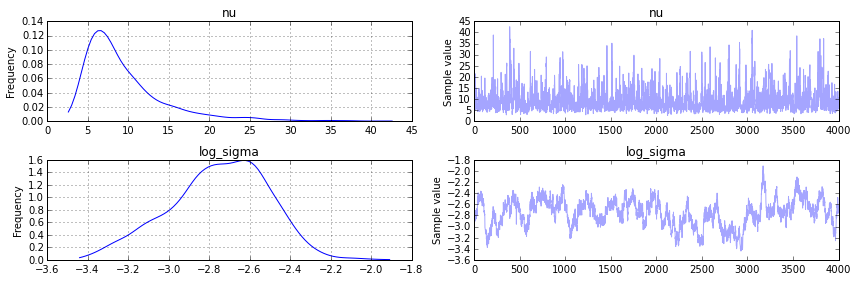

In [16]:
figsize(12,6)
pm.traceplot(trace, [nu, log_sigma]);

In [5]:
import pymc3
pymc3.

Finally we plot the distribution of volatility paths by plotting many of our sampled volatility paths on the same graph. Each is partially transparent so the regions where many paths overlap are shaded more darkly.

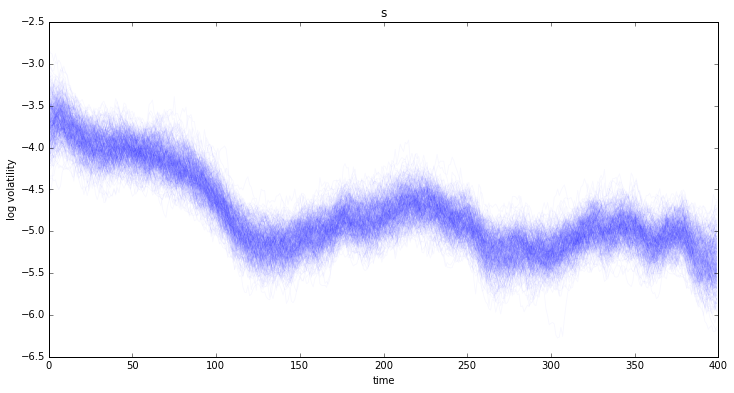

In [17]:
figsize(12,6)
title(str(s))
plot(trace[s][::10].T,'b', alpha=.03);
xlabel('time')
ylabel('log volatility')

## Case study 2: Occupancy estimation

Ecologists often use survey data to make inferences regarding the abundance and distribution of plants and animals. Such survey data is often *zero-inflated*, whereby there are more zeros than you would expect if the data were distributed according to some common distribution. This is sometimes due to habitat heterogeneity, which causes areas of low quality to be unoccupied by a particular species. However, some sites may be unoccupied simply due to chance.

Here is an example of such data; each element in the array (n=100) represents a count of a particular species among a set of sites. The data are clearly zero-inflated:

(array([ 65.,  11.,  15.,   3.,   3.,   1.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

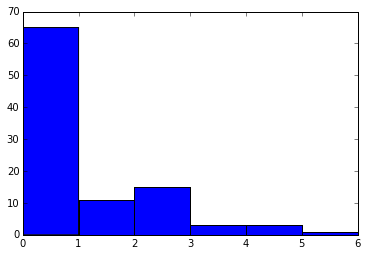

In [4]:
y = np.ma.masked_values([0, 2, 1, 0, 4, 2, 0, 0, -999, 0, 0, 0, 0, 0, -999, 0, 0, 6, 0, 0, 0, 2, 1,
       2, 0, 0, 0, 1, 0, 0, 0, 4, 2, 0, 0, 0, 1, 0, 2, 4, 0, 0, 1, 0, 0, 0,
       0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0,
       0, 0, 3, 0, 2, 0, 1, 2, 2, 2, 2, 3, 0, 0, 0, 0, 1, 0, 3, 1, 0, 0, 0,
       0, 0, 2, 0, 0, 1, 0, 0], value = -999)

x = np.array([0, 1, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0,
 1, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0,
 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0])


pl.hist(y, bins=range(7))

We can use a *mixture model* to represent this data. The mixture model contains two components an occupancy component, which determines whether a patch is suitable or not, and an abundance component that models the counts of organisms, conditional on occupancy. Given a random site, we can imagine it is inhabitable with some probability $p$ and uninhabitable with probability $1-p$. If it is inhabitable then it has an Poisson distributed organism count. If it is uninhabitable then it has a 0 organism count.

$$  
  p \sim Beta(1,1) \\
  z \sim Bernoulli(p) \\
  \theta \sim Uniform(0,100) \\
  y \sim ZeroInflatedPoisson(\theta, z) 
$$

PyMC3 includes a zero-inflated Poisson distribution among its standard distributions, which takes a conditional mean parameter as well as an array of indicators for the excess zeros. Since we do not know which zeros are excess a priori, this array is an unknown stochastic node in the model, distributed as a Bernoulli random variable, with a hyperparameter representing the occupancy rate.

In [42]:
from pymc3 import Beta, Bernoulli, ZeroInflatedPoisson, Uniform, Poisson

with Model() as zip_model:
    
    # Estimated occupancy
    p = Beta('p', 1, 1)

    # Latent variable for occupancy
    z = Bernoulli('z', p, y.shape)

    # Estimated mean count
    theta = Uniform('theta', 0, 100)

    # Poisson likelihood
    yd = ZeroInflatedPoisson('y', theta, z, observed=y)
    
    m = Normal('m', 1, 1)
    b = Normal('b', 1, 1)
    
    xd = Poisson('x', yd.data[0]*m+b, observed=x)

Notice that this model includes discrete random variables, the latent occupancy indicators. Hence, we cannot use a gradient-based MCMC step method like HMC or NUTS. Instead, we will sample using a `BinaryMetropolis` sampler that proposes only binary values at each iteration for `z`; for the continuous-valued parameters, `theta` and `p` we will use a standard `Metropolis` sampler. 

We sample with both samplers at once by passing them to `sample` in a list. Each new sample is generated by first applying `step1` then `step2`.

In [49]:
from pymc3 import Metropolis, BinaryMetropolis, sample 

with zip_model:
    
    start = {'p': 0.5, 'z': (y > 0).filled(1).astype(int), 'theta': 5, 'yd_missing': np.array([1,1])}
    

    step1 = Metropolis([theta, p, m, b] + yd.missing_values)

    step2 = BinaryMetropolis([z])

    trace = sample(10000, [step1, step2], start)

 [-----------------100%-----------------] 10000 of 10000 complete in 32.3 sec

In [40]:
yd.missing_values[0].tag.test_value = [1,1]
(yd.data[0]*m+b).tag.test_value

array([ 0.,  2.,  1.,  0.,  4.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,  2.,  1.,  2.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  4.,  2.,  0.,  0.,  0.,  1.,  0.,  2.,
        4.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  2.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        2.,  1.,  0.,  0.,  0.,  0.,  3.,  0.,  2.,  0.,  1.,  2.,  2.,
        2.,  2.,  3.,  0.,  0.,  0.,  0.,  1.,  0.,  3.,  1.,  0.,  0.,
        0.,  0.,  0.,  2.,  0.,  0.,  1.,  0.,  0.])

In [41]:
xd.logp_elemwise(start)

array([ 0.        , -1.30685282, -1.        ,  0.        , -1.92055846,
       -1.30685282,  0.        ,        -inf,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -2.41648106,  0.        ,  0.        ,
        0.        , -1.30685282, -1.        , -1.30685282,  0.        ,
        0.        ,  0.        , -1.        ,  0.        ,  0.        ,
        0.        , -1.92055846, -1.30685282,  0.        ,  0.        ,
        0.        , -1.        ,  0.        , -1.30685282, -1.92055846,
        0.        ,  0.        , -1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -1.30685282,  0.        ,
       -1.30685282,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -1.30685282, -1.        ,  0.        ,  0.        ,  0.  

The resulting posteriors for the unknown parameters suggest an occupancy rate in the neighborhood of 0.3 to 0.35, and an expected count (conditional on occupancy) of just over 2.

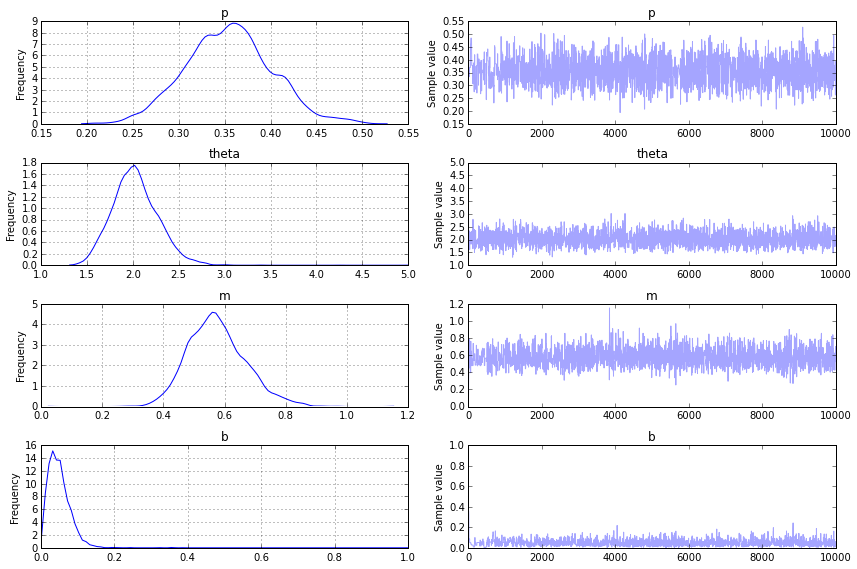

In [50]:
from pymc3 import traceplot, summary
traceplot(trace, ['p', 'theta', 'm', 'b']);

## Backends

`PyMC3` has support for different ways to store samples during and after sampling, called backends, including in-memory (default), text file, and SQLite. These can be found in `pymc.backends`:

By default, an in-memory `ndarray` is used but if the samples would get too large to be held in memory we could use the `sqlite` backend:

In [22]:
with basic_model:
    backend = pm.backends.SQLite('trace.sqlite')
    trace = pm.sample(500, Metropolis(), trace=backend)

 [-----------------100%-----------------] 500 of 500 complete in 0.5 sec

The stored trace can then later be loaded using the `load` command:

In [23]:
with basic_model:
    trace_loaded = pm.backends.sqlite.load('trace.sqlite')
    
trace_loaded 

<MultiTrace: 1 chains, 2500 iterations, 3 variables>

More information about `backends` can be found in the docstring of `pymc.backends`.

## Arbitrary deterministics

Through Theano, PyMC provides many mathematical functions and operators for transforming random variables into new random variables. Of course these do not cover all cases you might have, therefore Theano and PyMC provide functionality for creating your own arbitrary Theano functions in pure Python. This is supported with the `as_op` decorator.

Theano needs to know the types of the inputs and outputs of a function, which are specified for `as_op` by `itypes` for inputs and `otypes` for outputs. For an overview of the available types, see http://deeplearning.net/software/theano/library/tensor/basic.html#all-fully-typed-constructors.

**Note**: Because this function is now a blackbox function it is not possible for `theano` to inspect it and compute the gradient required for the Hamiltonian samplers. It is thus not possible to use the `HMC` or `NUTS` samplers for a model that uses such a distribution and you have to use e.g. `Metropolis` or `Slice` sampling. However, it is possible to add a gradient if we inherit from `theano.Op` instead of using `as_op`.

In [24]:
import theano.tensor as T 
import theano

@theano.compile.ops.as_op(itypes=[T.lscalar], otypes=[T.lscalar])
def crazy_modulo3(value):
    if value > 0: 
        return value % 3
    else :
        return (-value + 1) % 3
    
with Model() as model_deterministic:
    a = pm.Poisson('a', 1)
    b = crazy_modulo3(a)

For a more elaborate example of the usage of `as_op` we refer to the coal mining disaster model: https://github.com/pymc-devs/pymc/blob/master/pymc/examples/disaster_model_arbitrary_deterministic.py.

## Arbitrary distributions

In many cases, PyMC3 will not have a premade distribution for what you need. In these cases you will need to make our own custom distribution. There are two ways to do this. 

The first is to use `DensityDist`, which is a distribution that takes value $x$ and returns the $log(p(x))$ where $p$ is the probability density function of the distribution. This computation may include other random variables.

Below is an example inspired by a blog post by Jake Vanderplas on which priors to use for a linear regression. (Vanderplas, 2014). For more detail on the derivation of these priors we refer to the blog post.

In [25]:
import theano.tensor as T

with pm.Model() as model:
    alpha = pm.Uniform('intercept', -100, 100)
    
    # Create custom densities
    beta = pm.DensityDist('slope', lambda value: -1.5 * T.log(1 + value**2), testval=0)
    eps = pm.DensityDist('sigma', lambda value: -T.log(T.abs_(value)), testval=1)
    
    # Create likelihood
    like = pm.Normal('y_est', mu=alpha + beta * X, sd=eps, observed=Y)

The second method to create a new stochastic is to make a class that inherits from `Continuous` or `Discrete` and provide the `logp` function. This is the way the predefined distributions are written.

Many scientific fields including psychology and astrophysics have complex likelihood functions which are often a model of the process in question and have a complex form that may require numerical approximation. In these cases it is impossible to write the function in terms of predefined theano operators and we must use a custom theano operator using `as_op` or inheriting from `theano.Op`. 

Below we make a distribution like the one for `beta` above but with a mean parameter by making a class that inherits from `Continuous`. The distribution is usable in the normal way. We also use a custom operator using the `as_op` decorator, though this is not necessary.

In [26]:
class Beta(pm.distributions.Continuous):
    def __init__(self, mu, *args, **kwargs):
        super(Beta, self).__init__(*args, **kwargs)
        self.mu = mu
        self.mode = mu

    def logp(self, value):
        mu = self.mu
        return beta_logp(value - mu)
    
@theano.compile.ops.as_op(itypes=[T.dscalar], otypes=[T.dscalar])
def beta_logp(value):
    return -1.5 * np.log(1 + (value)**2)


with pm.Model() as model:
    beta = Beta('slope', mu=0, testval=0)

## Deterministic transformations

Above you have already seen that RVs in `PyMC3` can be easily combined and transformed (see the logistic regression example above). These transformations are called *deterministic*. However, note that in the above example we do not retain the samples of our transformed values (i.e. the `d`).  Using the `Deterministic` class we can explicitly add these deterministic variables to the trace.

# Generalized Linear Models

Generalized Linear Models (GLMs) are a class of widely used and flexible models to estimate relationships between a single outcome variable and one or multiple predictors. Above we have built Bayesian versions of linear as well as logistic regression. Because these models are so common, `PyMC3` offers a `glm` submodule that allows flexible creation of various GLMs with an intuitive `R`-like syntax that is implemented via the `patsy` module.

As the `glm` submodule requires data to be a `pandas` `DataFrame` we first have to convert `X` and `Y`:

In [27]:
# Convert X and Y to a pandas DataFrame
import pandas as pd
df = pd.DataFrame({'x': X, 'y': Y})

The above linear regression can then equivalently be written with the `glm` module as follows:

In [28]:
with pm.Model() as model_glm:
    pm.glm.glm('y ~ x', df)

The `glm` doc string provides an overview of the capabilities.

In [29]:
help(pm.glm.glm)

Help on function glm in module pymc3.glm.glm:

glm(*args, **kwargs)
    Create GLM after Patsy model specification string.
    
    Parameters
    ----------
    formula : str
        Patsy linear model descriptor.
    data : array
        Labeled array (e.g. pandas DataFrame, recarray).
    priors : dict
        Mapping prior name to prior distribution.
        E.g. {'Intercept': Normal.dist(mu=0, sd=1)}
    intercept_prior : pymc3 distribution
        Prior to use for the intercept.
        Default: Normal.dist(mu=0, tau=1.0E-12)
    regressor_prior : pymc3 distribution
        Prior to use for all regressor(s).
        Default: Normal.dist(mu=0, tau=1.0E-12)
    init_vals : dict
        Set starting values externally: parameter -> value
        Default: None
    family : Family object
        Distribution of likelihood, see pymc3.glm.families
        (init has to be True).
    
    Output
    ------
    vars : List of created random variables (y_est, coefficients etc)
    
    Examp

We can thus also specify a logistic regression by passing in a `Binomial` family object.

In [30]:
df_logistic = pd.DataFrame({'x': X, 'y': Y > 0})

with pm.Model() as model_glm_logistic:
    pm.glm.glm('y ~ x', 
               df_logistic,
               family=pm.glm.families.Binomial()
    )

## Conclusions

PyMC3 offers state-of-the-art sampling algorithms including Hamiltonian Monte Carlo. PyMC3 is also fast due to just-in-time compilation of the model to C, mathematical simplifications of the and caching of previously computed values we gain speed by just-in-time compilation of the model log-likelihood and it's gradient to C,  automatic gradient calculation

## References

Patil, A., D. Huard and C.J. Fonnesbeck. (2010) PyMC: Bayesian Stochastic Modelling in Python. Journal of Statistical Software, 35(4), pp. 1-81

Bastien, F., Lamblin, P., Pascanu, R., Bergstra, J., Goodfellow, I., Bergeron, A., Bouchard, N., Warde-Farley, D., and Bengio, Y. (2012) “Theano: new features and speed improvements”. NIPS 2012 deep learning workshop.

Bergstra, J., Breuleux, O., Bastien, F., Lamblin, P., Pascanu, R., Desjardins, G., Turian, J., Warde-Farley, D., and Bengio, Y. (2010) “Theano: A CPU and GPU Math Expression Compiler”. Proceedings of the Python for Scientific Computing Conference (SciPy) 2010. June 30 - July 3, Austin, TX

Lunn, D.J., Thomas, A., Best, N., and Spiegelhalter, D. (2000) WinBUGS -- a Bayesian modelling framework: concepts, structure, and extensibility. Statistics and Computing, 10:325--337.

Neal, R.M. Slice sampling. Annals of Statistics. (2003). doi:10.2307/3448413.

van Rossum, G. The Python Library Reference Release 2.6.5., (2010). URL http://docs.python.org/library/.

Duane, S., Kennedy, A. D., Pendleton, B. J., and Roweth, D. (1987) “Hybrid Monte Carlo”, Physics Letters, vol. 195, pp. 216-222.

Stan Development Team. (2014). Stan: A C++ Library for Probability and Sampling, Version 2.5.0.   http://mc-stan.org. 

Gamerman, D. Markov Chain Monte Carlo: statistical simulation for Bayesian inference. Chapman and Hall, 1997.

Hoffman, M. D., & Gelman, A. (2014). The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo. The Journal of Machine Learning Research, 30.

Vanderplas, Jake. "Frequentism and Bayesianism IV: How to be a Bayesian in Python." Pythonic Perambulations. N.p., 14 Jun 2014. Web. 27 May. 2015. <https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/>.